In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.mstats import winsorize

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

# Đọc file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hanoi-aqi-weather-data.csv')
# link data 'https://github.com/namanhnt/Hanoi-Air-Quality-Analysis/blob/main/Data/hanoi-aqi-weather-data.csv'


Mounted at /content/drive


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8785 entries, 0 to 8784
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Local Time         8785 non-null   object 
 1   UTC Time           8785 non-null   object 
 2   City               8785 non-null   object 
 3   Country Code       8785 non-null   object 
 4   Timezone           8785 non-null   object 
 5   AQI                8785 non-null   int64  
 6   CO                 8785 non-null   float64
 7   NO2                8785 non-null   float64
 8   O3                 8785 non-null   float64
 9   PM10               8785 non-null   float64
 10  PM25               8785 non-null   float64
 11  SO2                8785 non-null   float64
 12  Clouds             8785 non-null   int64  
 13  Precipitation      8785 non-null   float64
 14  Pressure           8785 non-null   int64  
 15  Relative Humidity  8785 non-null   int64  
 16  Temperature        8785 

In [ ]:
# Check dữ liệu
print("Shape:", df.shape)
print(df.head())
print(df.columns.tolist())

Shape: (8785, 19)
            Local Time             UTC Time   City Country Code  \
0  2023-03-08 00:00:00  2023-03-07T17:00:00  Hanoi           VN   
1  2023-03-08 01:00:00  2023-03-07T18:00:00  Hanoi           VN   
2  2023-03-08 02:00:00  2023-03-07T19:00:00  Hanoi           VN   
3  2023-03-08 03:00:00  2023-03-07T20:00:00  Hanoi           VN   
4  2023-03-08 04:00:00  2023-03-07T21:00:00  Hanoi           VN   

           Timezone  AQI     CO   NO2    O3  PM10  PM25   SO2  Clouds  \
0  Asia/Ho_Chi_Minh  131  170.6  29.3  53.3  58.8  47.0  67.3      91   
1  Asia/Ho_Chi_Minh  126  158.7  25.0  54.0  56.3  45.0  65.0     100   
2  Asia/Ho_Chi_Minh  118  150.2  21.7  55.0  52.5  42.0  65.7     100   
3  Asia/Ho_Chi_Minh  126  141.6  18.3  56.0  56.3  45.0  66.3     100   
4  Asia/Ho_Chi_Minh  118  133.1  15.0  57.0  52.5  42.0  67.0     100   

   Precipitation  Pressure  Relative Humidity  Temperature  UV Index  \
0            0.0      1016                 86         21.2       0.0

In [ ]:
df.dtypes

,0
Local Time,object
UTC Time,object
City,object
Country Code,object
Timezone,object
AQI,int64
CO,float64
NO2,float64
O3,float64
PM10,float64


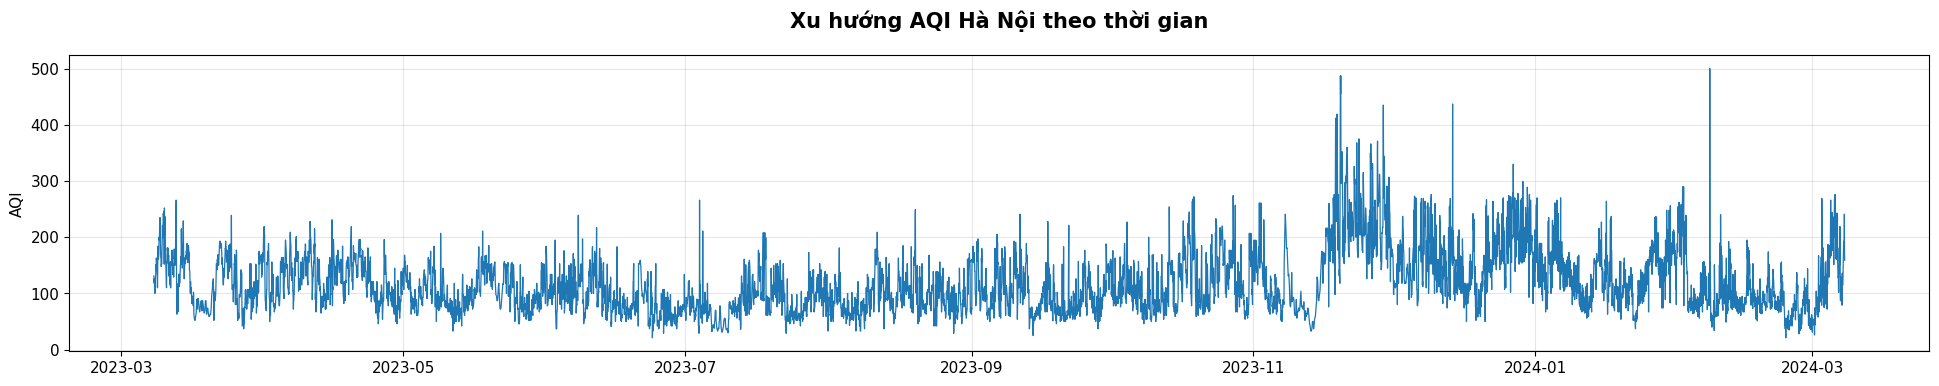

In [ ]:


# ====== TÌM CỘT THỜI GIAN ======
time_col = next(
    (col for col in df.columns if any(kw in col.lower() for kw in ['time', 'date', 'timestamp'])),
    df.columns[0]
)

# ====== TÌM CỘT AQI ======
aqi_candidates = ['aqi', 'air quality index']
aqi_col = next(
    (col for col in df.columns if any(kw in col.lower() for kw in aqi_candidates)),
    None
)

if aqi_col is None:
    raise ValueError("Không tìm thấy cột AQI trong dataset!")

# ====== CHUYỂN SANG DATETIME ======
df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
df = df.dropna(subset=[time_col, aqi_col]).reset_index(drop=True)

# ====== TẠO CỘT THỨC THỜI GIAN ======
df['hour'] = df[time_col].dt.hour
df['month'] = df[time_col].dt.month
df['weekday'] = df[time_col].dt.weekday
df['date'] = df[time_col].dt.date

# ====== BẮT ĐẦU VẼ ======
plt.rcParams['font.size'] = 11
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.35)

# ===== 1. AQI theo thời gian =====
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(df[time_col], df[aqi_col], linewidth=0.9)
ax1.set_title('Xu hướng AQI Hà Nội theo thời gian', fontsize=15, fontweight='bold', pad=20)
ax1.set_ylabel('AQI')
ax1.grid(alpha=0.3)


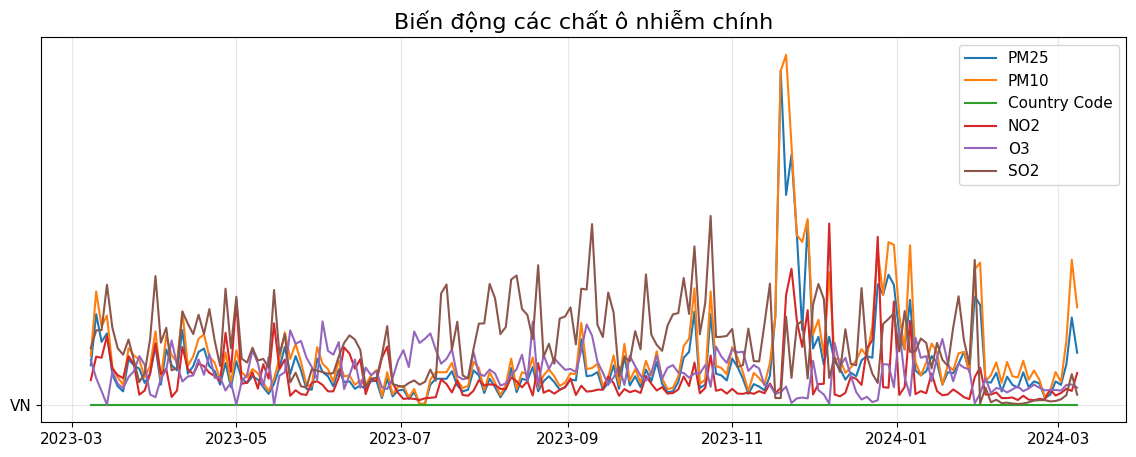

In [ ]:
plt.figure(figsize=(14,5))

pollutants = ['PM2.5','PM25','PM10','CO','NO2','O3','SO2']
pollutants = [p for p in pollutants if any(p.lower() in col.lower() for col in df.columns)]

for p in pollutants:
    col = next(c for c in df.columns if p.lower() in c.lower())
    plt.plot(df[time_col].iloc[::48], df[col].iloc[::48], label=col)

plt.title("Biến động các chất ô nhiễm chính", fontsize=16)
plt.legend()
plt.grid(alpha=0.3)
plt.show()


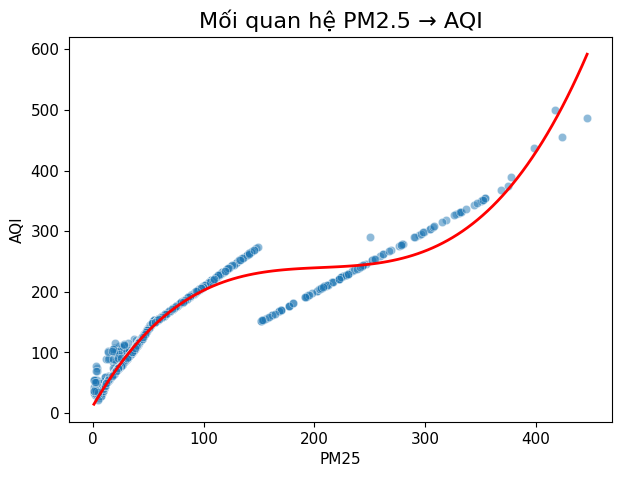

In [ ]:
pm25 = next((c for c in df.columns if 'pm2.5' in c.lower() or 'pm25' in c.lower()), None)

plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(min(3000, len(df))), x=pm25, y=aqi_col, alpha=0.5)

# Fit đường cong bậc 3
z = np.polyfit(df[pm25], df[aqi_col], 3)
p = np.poly1d(z)
xp = np.linspace(df[pm25].min(), df[pm25].max(), 100)
plt.plot(xp, p(xp), color='red', linewidth=2)

plt.title("Mối quan hệ PM2.5 → AQI", fontsize=16)
plt.show()


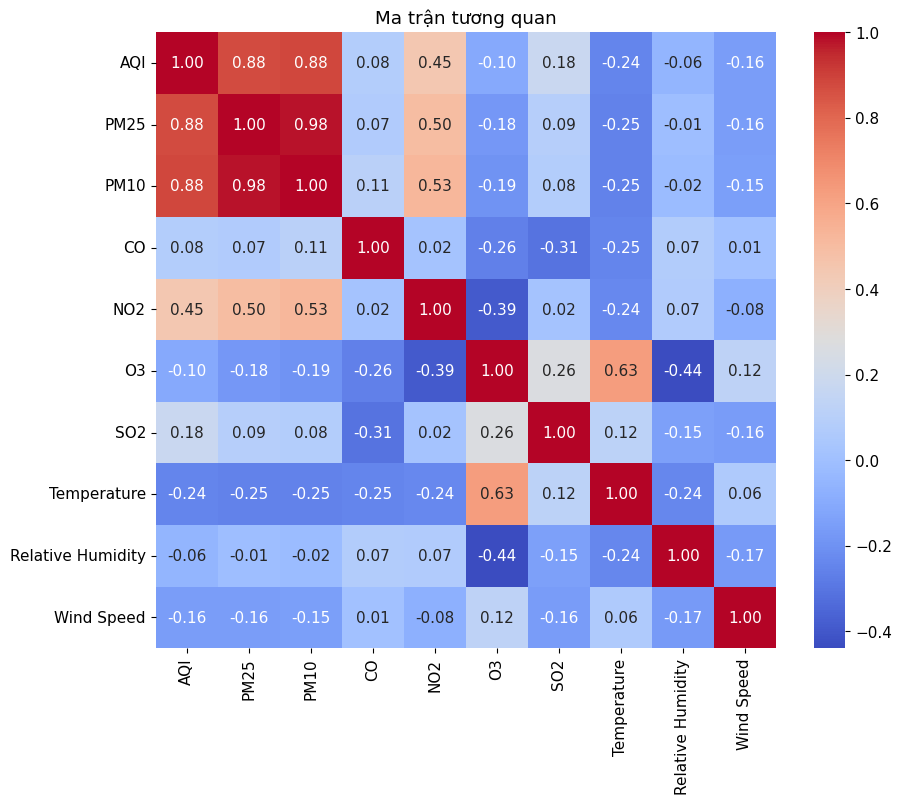

In [ ]:
pm25_col = next((c for c in df.columns if "pm" in c.lower() and "25" in c.lower()), None)
pm10_col = next((c for c in df.columns if "pm" in c.lower() and "10" in c.lower()), None)

cols = [aqi_col, pm25_col, pm10_col, "CO", "NO2", "O3", "SO2",
        "Temperature", "Relative Humidity", "Wind Speed"]

# Loại bỏ cột None
cols = [c for c in cols if c is not None]

corr = df[cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan")
plt.show()


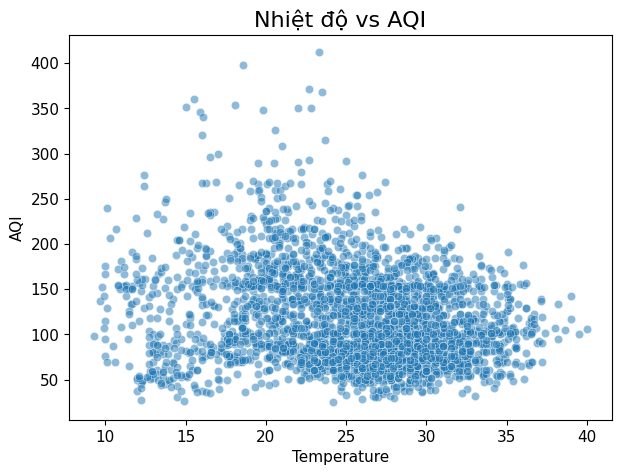

In [ ]:
temp_col = next((c for c in df.columns if "temperature" in c.lower()), None)

plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(min(3000, len(df))), x=temp_col, y=aqi_col, alpha=0.5)
plt.title("Nhiệt độ vs AQI", fontsize=16)
plt.show()


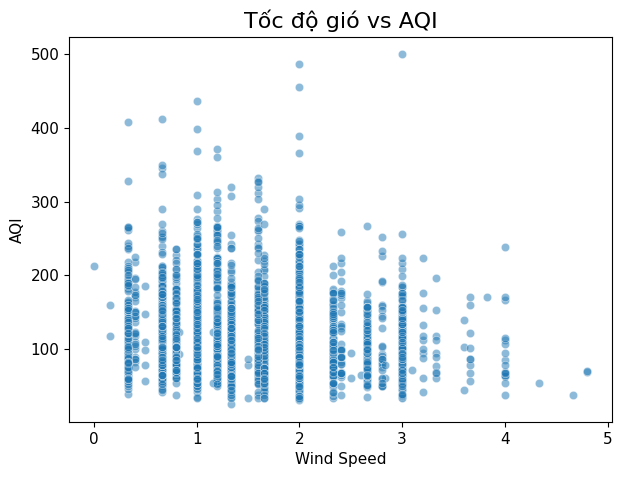

In [ ]:
wind_col = next((c for c in df.columns if "wind speed" in c.lower()), None)

plt.figure(figsize=(7,5))
sns.scatterplot(data=df.sample(min(3000, len(df))), x=wind_col, y=aqi_col, alpha=0.5)
plt.title("Tốc độ gió vs AQI", fontsize=16)
plt.show()


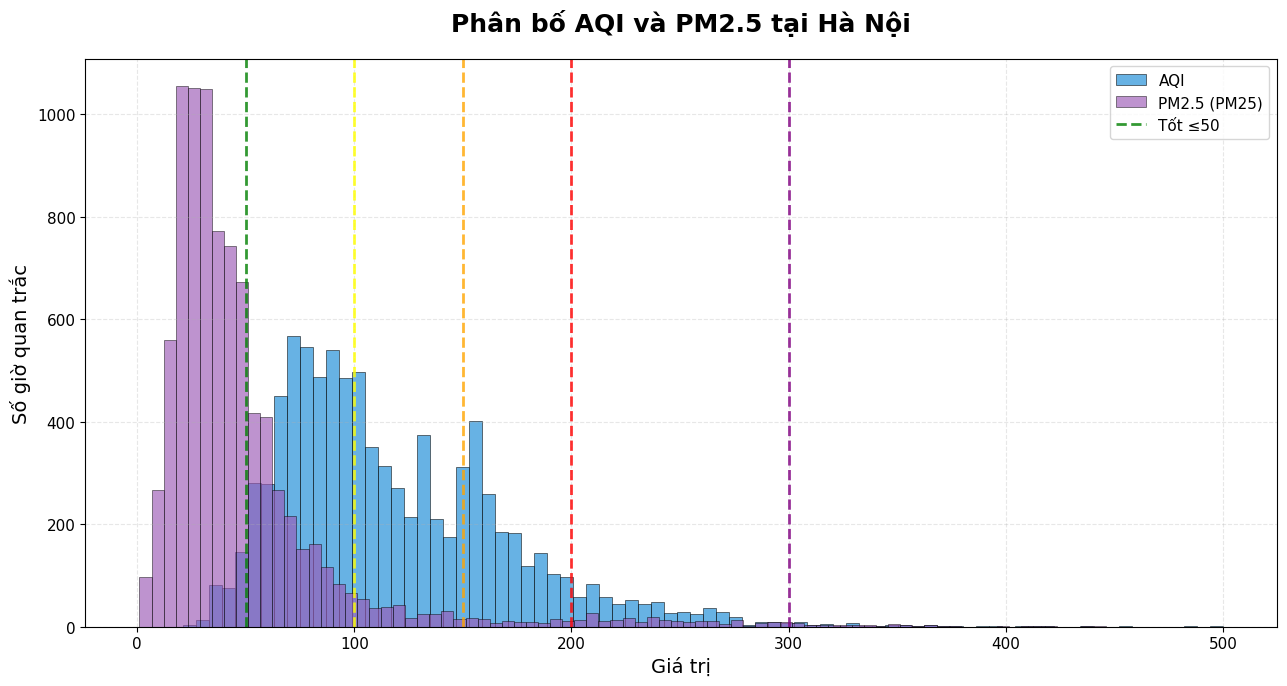

In [ ]:
pm25_col = None
for col in df.columns:
    if 'pm' in col.lower() and ('2.5' in col or '25' in col):
        pm25_col = col
        break
plt.figure(figsize=(13, 7))

# Histogram AQI
plt.hist(df[aqi_col].dropna(), bins=80, alpha=0.75, color='#3498DB', edgecolor='black', linewidth=0.5, label='AQI')

# Histogram PM2.5 (nếu tìm thấy)
if pm25_col in df.columns:
    plt.hist(df[pm25_col].dropna(), bins=80, alpha=0.65, color='#9B59B6', edgecolor='black', linewidth=0.5, label=f'PM2.5 ({pm25_col})')

# Làm đẹp
plt.title('Phân bố AQI và PM2.5 tại Hà Nội', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Giá trị', fontsize=14)
plt.ylabel('Số giờ quan trắc', fontsize=14)
plt.legend(fontsize=13)
plt.grid(alpha=0.3, linestyle='--')

# Đường phân mức AQI
plt.axvline(50, color='green', linestyle='--', linewidth=2, alpha=0.8, label='Tốt ≤50')
plt.axvline(100, color='yellow', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(150, color='orange', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(200, color='red', linestyle='--', linewidth=2, alpha=0.8)
plt.axvline(300, color='purple', linestyle='--', linewidth=2, alpha=0.8)

plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

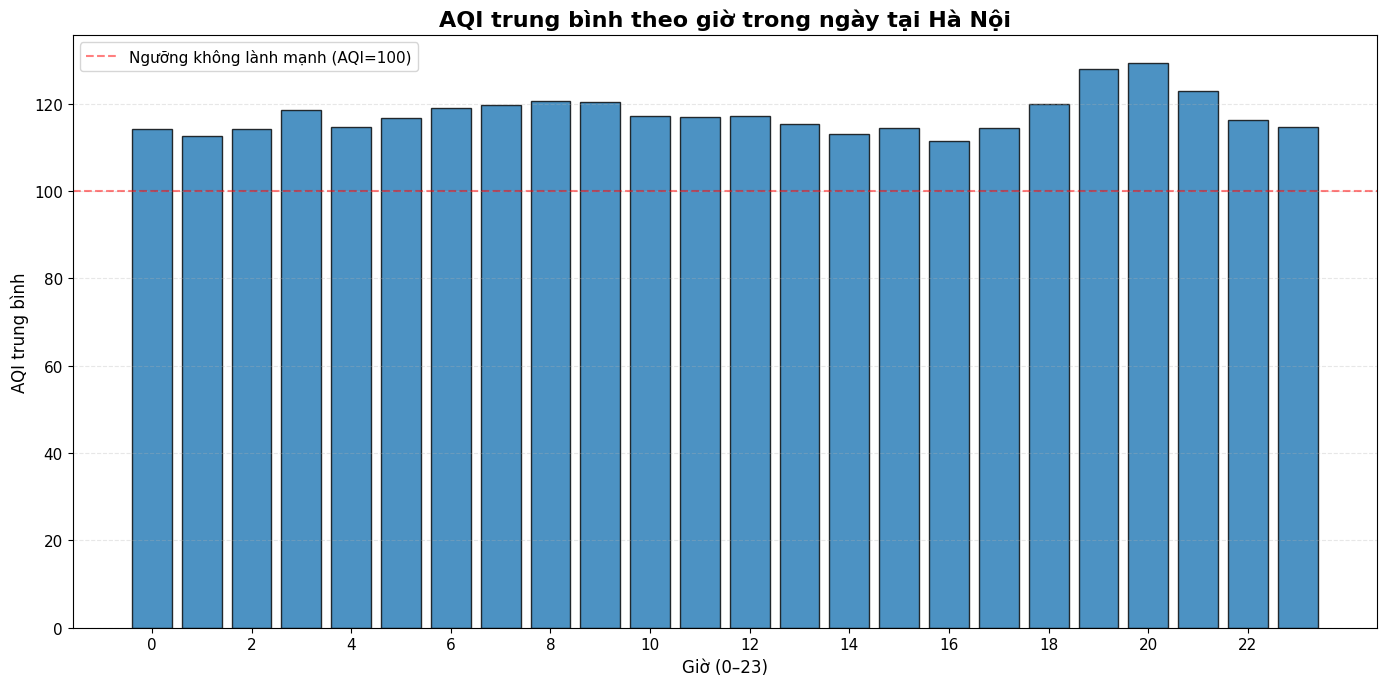

In [ ]:
# Reload data for plotting purposes to ensure time columns are present
df_plot = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hanoi-aqi-weather-data.csv')

# 1. Tìm cột thời gian chính xác
time_col = next(
    (col for col in df_plot.columns if any(kw in col.lower() for kw in ['time', 'date', 'timestamp'])),
    df_plot.columns[0] # Fallback to first column if no specific time column name is found
)

# 2. Tìm cột AQI
aqi_col = next(
    (col for col in df_plot.columns if any(kw in col.lower() for kw in ['aqi', 'air quality index'])),
    None
)

if aqi_col is None:
    raise ValueError("Không tìm thấy cột AQI trong dataset!")

# 3. Chuyển sang datetime + trích giờ
df_plot[time_col] = pd.to_datetime(df_plot[time_col], errors='coerce')
df_plot = df_plot.dropna(subset=[time_col, aqi_col]).reset_index(drop=True)
df_plot['hour'] = df_plot[time_col].dt.hour

# 4. Tính trung bình theo giờ
hourly = df_plot.groupby('hour')[aqi_col].mean()

# 5. Vẽ biểu đồ
plt.figure(figsize=(14, 7))
plt.bar(hourly.index, hourly.values, color='#1f77b4', edgecolor='black', alpha=0.8)
plt.title('AQI trung bình theo giờ trong ngày tại Hà Nội', fontsize=16, fontweight='bold')
plt.xlabel('Giờ (0–23)', fontsize=12)
plt.ylabel('AQI trung bình', fontsize=12)
plt.xticks(range(0, 24, 2))  # Hiển thị mỗi 2 giờ
plt.axhline(y=100, color='red', linestyle='--', alpha=0.5, label='Ngưỡng không lành mạnh (AQI=100)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

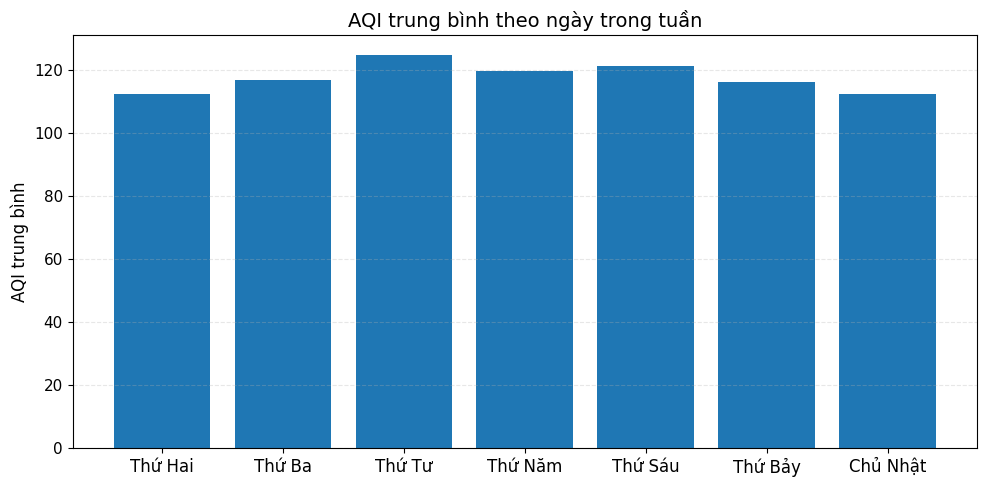

In [ ]:
# Reload data for plotting purposes to ensure time columns are present
df_plot = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hanoi-aqi-weather-data.csv')

# 1. Tìm cột thời gian chính xác
time_col = next(
    (col for col in df_plot.columns if any(kw in col.lower() for kw in ['time', 'date', 'timestamp'])),
    df_plot.columns[0] # Fallback to first column if no specific time column name is found
)

# 2. Tìm cột AQI
aqi_col = next(
    (col for col in df_plot.columns if any(kw in col.lower() for kw in ['aqi', 'air quality index'])),
    None
)

if aqi_col is None:
    raise ValueError("Không tìm thấy cột AQI trong dataset!")

# 3. Chuyển sang datetime + trích weekday
df_plot[time_col] = pd.to_datetime(df_plot[time_col], errors='coerce')
df_plot = df_plot.dropna(subset=[time_col, aqi_col]).reset_index(drop=True)
df_plot['weekday'] = df_plot[time_col].dt.weekday # Monday=0, Sunday=6

# 4. Tính AQI trung bình theo ngày trong tuần
weekly = df_plot.groupby('weekday')[aqi_col].mean()

days = ["Thứ Hai", "Thứ Ba", "Thứ Tư", "Thứ Năm", "Thứ Sáu", "Thứ Bảy", "Chủ Nhật"]

plt.figure(figsize=(10,5))
plt.bar(range(7), weekly.values)

plt.xticks(range(7), days, fontsize=12)
plt.ylabel("AQI trung bình", fontsize=12)
plt.title("AQI trung bình theo ngày trong tuần", fontsize=14)

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# TIỀN XỬ LÝ
feature_cols = ['PM2.5', 'PM10', 'CO', 'NO2', 'O3', 'SO2',
                'Temperature', 'Relative Humidity', 'Wind Speed',
                'Precipitation', 'Pressure', 'Clouds']

# Lọc chỉ lấy các cột tồn tại
available_features = [col for col in feature_cols if col in df.columns]
df = df[['AQI'] + available_features].dropna()

print(f"Đang dùng {len(available_features)} đặc trưng: {available_features}")
print("Số dòng sau khi xử lý missing:", len(df))

X = df[available_features]
y = df['AQI']

Đang dùng 11 đặc trưng: ['PM10', 'CO', 'NO2', 'O3', 'SO2', 'Temperature', 'Relative Humidity', 'Wind Speed', 'Precipitation', 'Pressure', 'Clouds']
Số dòng sau khi xử lý missing: 8785


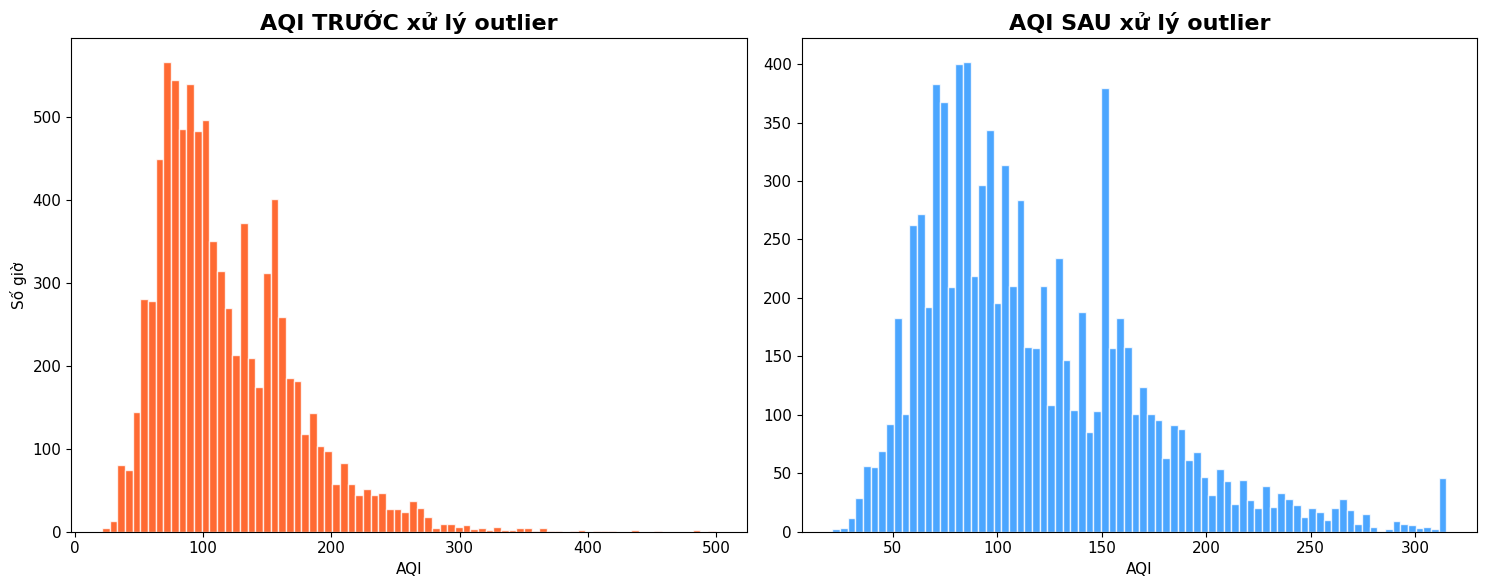

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

# Tự dò cột AQI và PM2.5 (chạy được với mọi tên cột)
aqi_col = next(col for col in df.columns if 'aqi' in col.lower())
pm25_col = next((col for col in df.columns if 'pm2.5' in col.lower() or 'pm25' in col.lower()), None)

# Tạo bản sao để xử lý
temp = df.copy()
temp[aqi_col] = winsorize(temp[aqi_col], limits=[0, 0.005])

# VẼ 2 BIỂU ĐỒ TRƯỚC - SAU
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.hist(df[aqi_col], bins=80, color='orangered', alpha=0.8, edgecolor='white')
plt.title('AQI TRƯỚC xử lý outlier', fontsize=16, fontweight='bold')
plt.xlabel('AQI')
plt.ylabel('Số giờ')

plt.subplot(1,2,2)
plt.hist(temp[aqi_col], bins=80, color='dodgerblue', alpha=0.8, edgecolor='white')
plt.title('AQI SAU xử lý outlier', fontsize=16, fontweight='bold')
plt.xlabel('AQI')

plt.tight_layout()
plt.show()

In [ ]:
# CHIA DỮ LIỆU
split_idx = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {len(X_train)} dòng | Test: {len(X_test)} dòng")

Train: 7028 dòng | Test: 1757 dòng


LINEAR REGRESSION
              precision    recall  f1-score   support

    negative       0.91      0.58      0.71       744
    positive       0.76      0.96      0.84      1013

    accuracy                           0.80      1757
   macro avg       0.83      0.77      0.78      1757
weighted avg       0.82      0.80      0.79      1757

Confusion Matrix:
[[430 314]
 [ 43 970]]
Accuracy : 0.7968
AUC : 0.500000000000


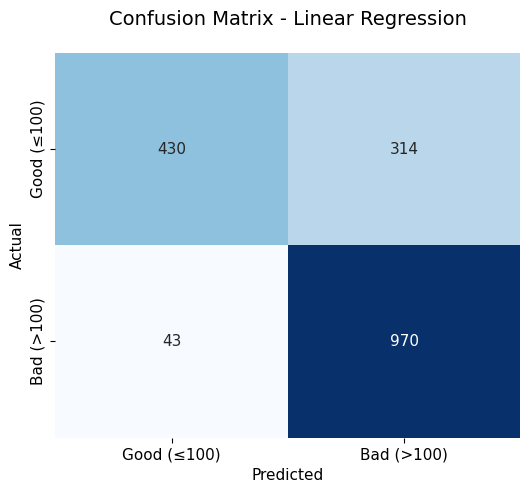

-----------------------------------------------------------------


In [ ]:
y_train_bin = (y_train > 100).astype(int)
y_test_bin  = (y_test > 100).astype(int)

# LINEAR REGRESSION
print("LINEAR REGRESSION")
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_cont_lr = lr.predict(X_test)
pred_bin_lr  = (pred_cont_lr > 100).astype(int)
pred_proba_lr = 1 / (1 + np.exp(-pred_cont_lr))  # sigmoid

print(classification_report(y_test_bin, pred_bin_lr, target_names=['negative', 'positive'], digits=2))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, pred_bin_lr))
print(f"Accuracy : {accuracy_score(y_test_bin, pred_bin_lr):.4f}")
print(f"AUC : {roc_auc_score(y_test_bin, pred_proba_lr):.12f}")

# CONFUSION MATRIX
plt.figure(figsize=(6,5))
cm_lr = confusion_matrix(y_test_bin, pred_bin_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Good (≤100)', 'Bad (>100)'],
            yticklabels=['Good (≤100)', 'Bad (>100)'])
plt.title('Confusion Matrix - Linear Regression', fontsize=14, pad=20)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("-" * 65)

RANDOM FOREST
              precision    recall  f1-score   support

    negative       0.88      0.88      0.88       744
    positive       0.91      0.91      0.91      1013

    accuracy                           0.90      1757
   macro avg       0.90      0.90      0.90      1757
weighted avg       0.90      0.90      0.90      1757

Confusion Matrix:
[[655  89]
 [ 89 924]]
Accuracy : 0.8987
AUC : 0.962548031504


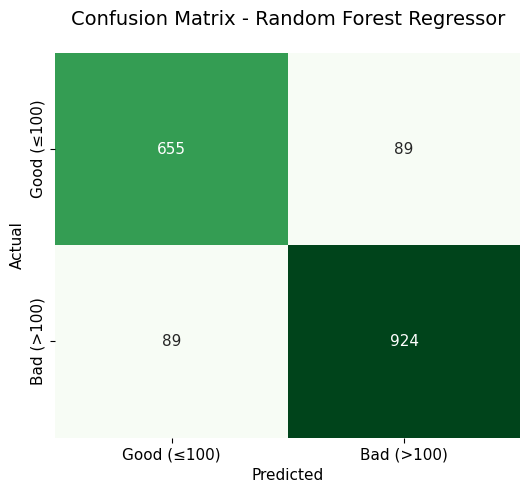

In [ ]:
# RANDOM FOREST
print("RANDOM FOREST")
rf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
pred_cont_rf = rf.predict(X_test)
pred_bin_rf  = (pred_cont_rf > 100).astype(int)
pred_proba_rf = pred_cont_rf / pred_cont_rf.max()  # giả lập xác suất

print(classification_report(y_test_bin, pred_bin_rf, target_names=['negative', 'positive'], digits=2))
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, pred_bin_rf))
print(f"Accuracy : {accuracy_score(y_test_bin, pred_bin_rf):.4f}")
print(f"AUC : {roc_auc_score(y_test_bin, pred_proba_rf):.12f}")

# CONFUSION MATRIX
plt.figure(figsize=(6,5))
cm_rf = confusion_matrix(y_test_bin, pred_bin_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Good (≤100)', 'Bad (>100)'],
            yticklabels=['Good (≤100)', 'Bad (>100)'])
plt.title('Confusion Matrix - Random Forest Regressor', fontsize=14, pad=20)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print("=" * 65)

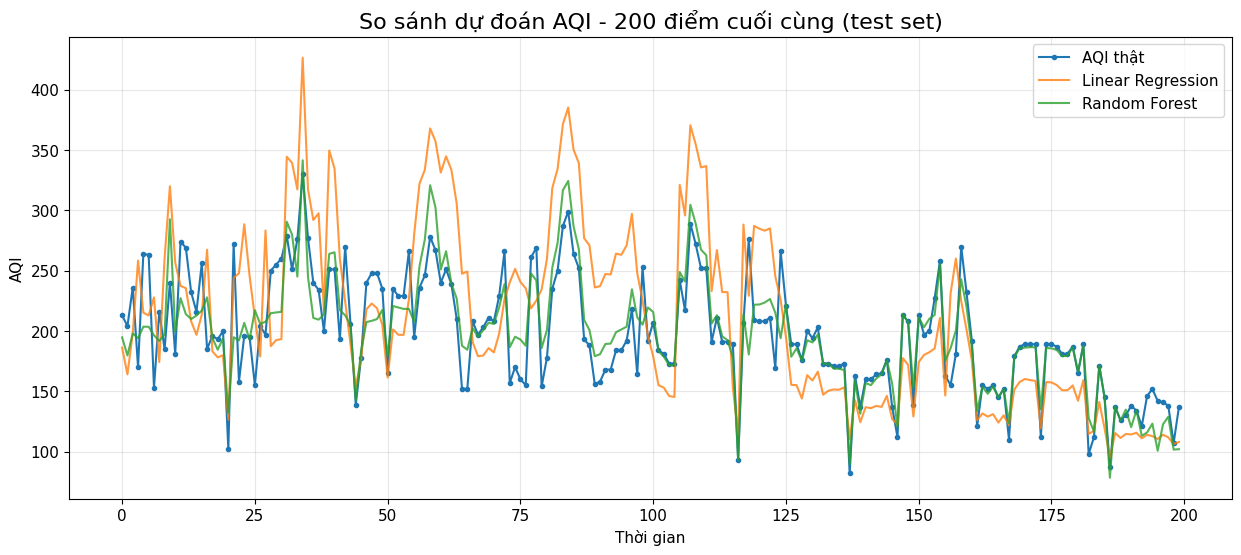

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values[:200], label='AQI thật', marker='o', markersize=3)
plt.plot(pred_cont_lr[:200], label='Linear Regression', alpha=0.8)
plt.plot(pred_cont_rf[:200], label='Random Forest', alpha=0.8)
plt.title('So sánh dự đoán AQI - 200 điểm cuối cùng (test set)', fontsize=16)
plt.xlabel('Thời gian')
plt.ylabel('AQI')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()